<a href="https://colab.research.google.com/github/heroza/Experiment-0/blob/main/ISIC%20Classification%20with%209%20classes%20using%20ResNet-50%20TL%20with%20Fine%20Tuning%20SMOTE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Prepare the dataset. 
Currently, we use skin cancer ISIC dataset from Kaggle https://www.kaggle.com/datasets/nodoubttome/skin-cancer9-classesisic

Tutorial for how to load Kaggle dataset can be found in https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/

In [1]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download nodoubttome/skin-cancer9-classesisic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
100% 785M/786M [00:10<00:00, 81.6MB/s]
100% 786M/786M [00:10<00:00, 76.0MB/s]


In [2]:
! unzip /content/skin-cancer9-classesisic.zip

Archive:  /content/skin-cancer9-classesisic.zip
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024654.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024707.jpg  
  inflating: Ski

Load Data

In [3]:
from pathlib import Path
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
def load_data(path: str):
    dir = Path(path)
    # list of all filepathes
    filepaths = list(dir.glob(r'**/*.jpg'))
    # list of labels extracted from last foldername of filepath
    labels = list(map(lambda l: os.path.split(os.path.split(l)[0])[1], filepaths))
    # series of string filepathes
    filepaths = pd.Series(filepaths, name='FilePaths').astype(str)
    # series of string labels
    labels = pd.Series(labels, name='Labels').astype(str)
    # merge series to dataframe df
    df = pd.merge(filepaths, labels, right_index=True, left_index=True)
    # Resampling complete rows and reset the index
    return df.sample(frac=1).reset_index(drop=True)


df = load_data('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train')

In [5]:
len(df.index)

2239

In [6]:
df.head(3)

,FilePaths,Labels
0,/content/Skin cancer ISIC The International Sk...,vascular lesion
1,/content/Skin cancer ISIC The International Sk...,nevus
2,/content/Skin cancer ISIC The International Sk...,seborrheic keratosis


Label Distribution

[Text(0, 0, 'seborrheic keratosis'),
 Text(0, 0, 'dermatofibroma'),
 Text(0, 0, 'actinic keratosis'),
 Text(0, 0, 'vascular lesion'),
 Text(0, 0, 'squamous cell carcinoma'),
 Text(0, 0, 'nevus'),
 Text(0, 0, 'basal cell carcinoma'),
 Text(0, 0, 'melanoma'),
 Text(0, 0, 'pigmented benign keratosis')]

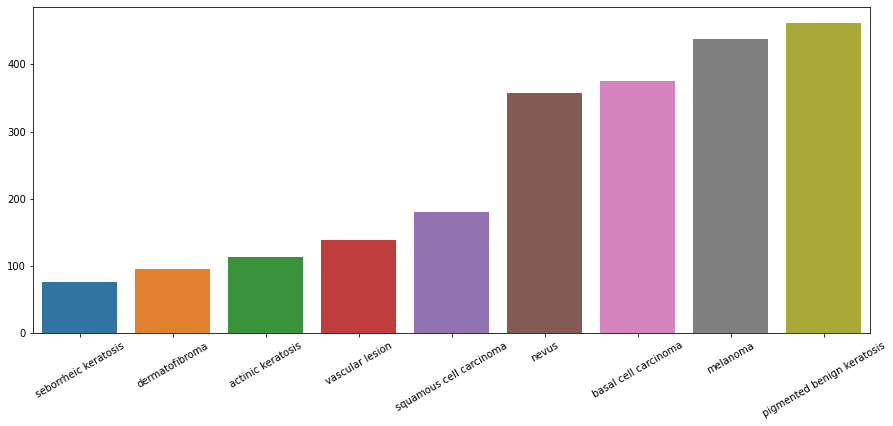

In [7]:
# ordered count of rows per unique label
labels_count = df['Labels'].value_counts(ascending=True)

f = plt.figure(figsize=(15, 6))
s = sns.barplot(x=labels_count.index,y=labels_count.values)
s.set_xticklabels(s.get_xticklabels(), rotation = 30)

Plot 3 images per label

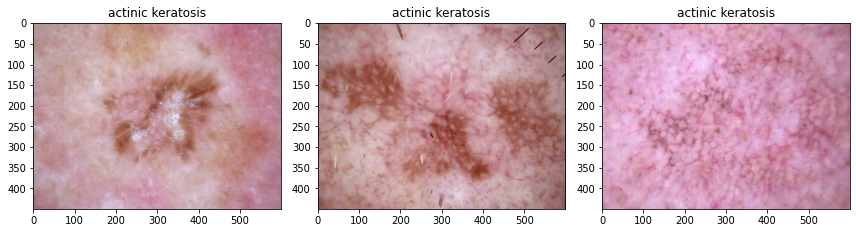

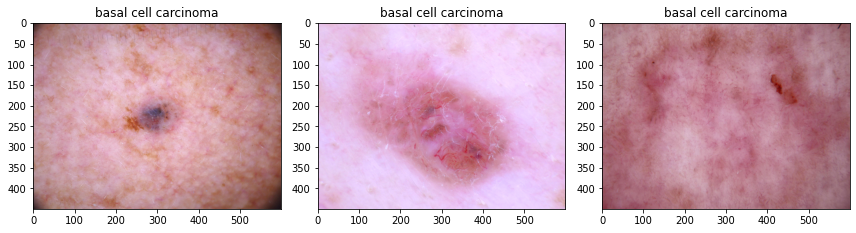

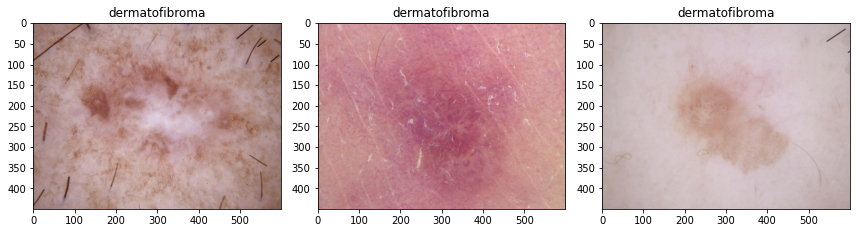

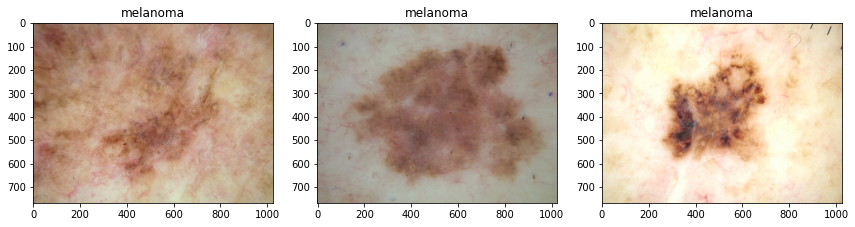

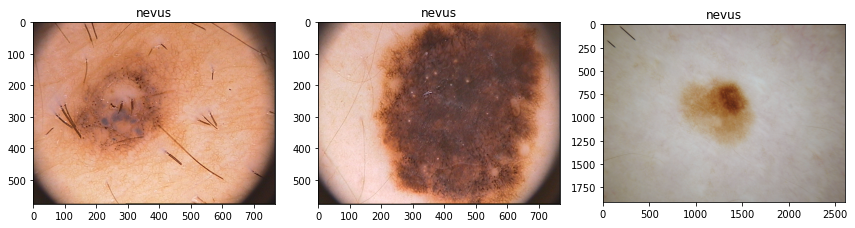

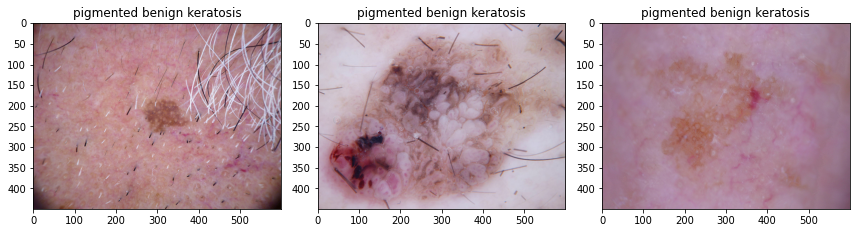

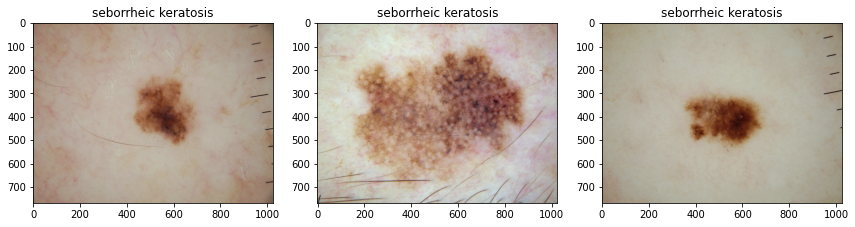

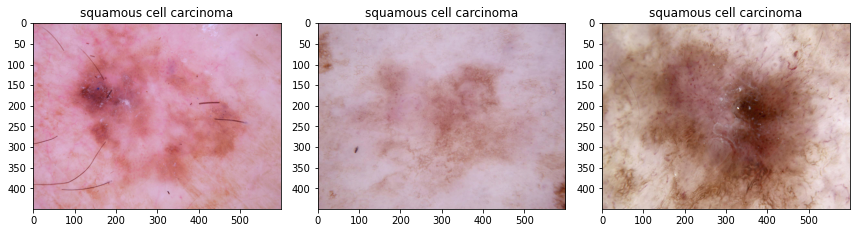

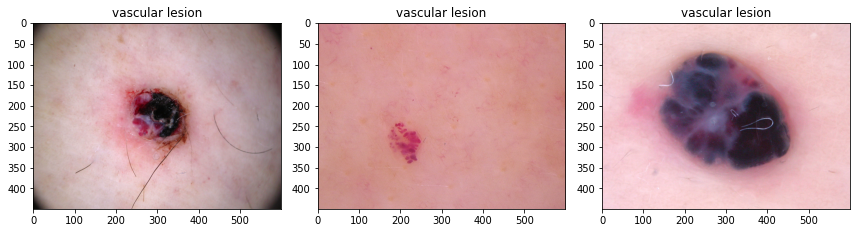

In [8]:
def plot_images_per_label(df, label, cols: int, size: tuple):
    fig, axs = plt.subplots(nrows=1, ncols=cols, figsize=size)

    cntMax = cols
    cntCur = 0
    for index, row in df.iterrows():
        if(row['Labels'] == label and cntCur < cntMax):
            axs[cntCur].imshow(plt.imread(df.FilePaths[index]))
            axs[cntCur].set_title(df.Labels[index])

            cntCur += 1
        else:
            if(cntCur >= cntMax):
                break
    
    plt.tight_layout()
    plt.show()


# unique labels
labels = sorted(df['Labels'].unique())
# loop through labels
for label in labels:
    plot_images_per_label(df, label, 3, (12,9))

Dataset Balancer

In [11]:
!pip install imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
# check version number
import imblearn
print(imblearn.__version__)

0.8.1


Prepare X,y

In [15]:
y = df['Labels']
X = df.drop('Labels', 1)

# summarize class distribution
from collections import Counter
counter = Counter(y)
print(counter)

Counter({'pigmented benign keratosis': 462, 'melanoma': 438, 'basal cell carcinoma': 376, 'nevus': 357, 'squamous cell carcinoma': 181, 'vascular lesion': 139, 'actinic keratosis': 114, 'dermatofibroma': 95, 'seborrheic keratosis': 77})


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


Transform

In [17]:
# transform the dataset
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

# summarize class distribution
from collections import Counter
counter = Counter(y)
print(counter)

ValueError: ignored

Split dataset to train and val

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
# stratified train and val (20%) datasets
X_train, X_val = train_test_split(df, test_size=0.2, stratify=df['Labels'], random_state=1)

print('Train Data: ', X_train.shape)
print('Val Data: ', X_val.shape)

Train Data:  (1791, 2)
Val Data:  (448, 2)


Data Augmentation

In [ ]:
from keras.applications.resnet import preprocess_input
from keras_preprocessing.image import ImageDataGenerator

In [ ]:
# number of samples/images per iteration
BATCH_SIZE = 32
# input image size
IMG_SIZE = (224,224) #use AlexNet inpu size instead (224, 224)

In [ ]:
img_data_gen = ImageDataGenerator(shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  preprocessing_function=preprocess_input)

X_train = img_data_gen.flow_from_dataframe(dataframe=X_train,
                                           x_col='FilePaths',
                                           y_col='Labels',
                                           target_size=IMG_SIZE,
                                           color_mode='rgb',
                                           class_mode='categorical',
                                           batch_size=BATCH_SIZE,
                                           seed=1)

X_val = img_data_gen.flow_from_dataframe(dataframe=X_val,
                                         x_col='FilePaths',
                                         y_col='Labels',
                                         target_size=IMG_SIZE,
                                         color_mode='rgb',
                                         class_mode='categorical',
                                         batch_size=BATCH_SIZE,
                                         seed=1)

Found 1791 validated image filenames belonging to 9 classes.
Found 448 validated image filenames belonging to 9 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input dat

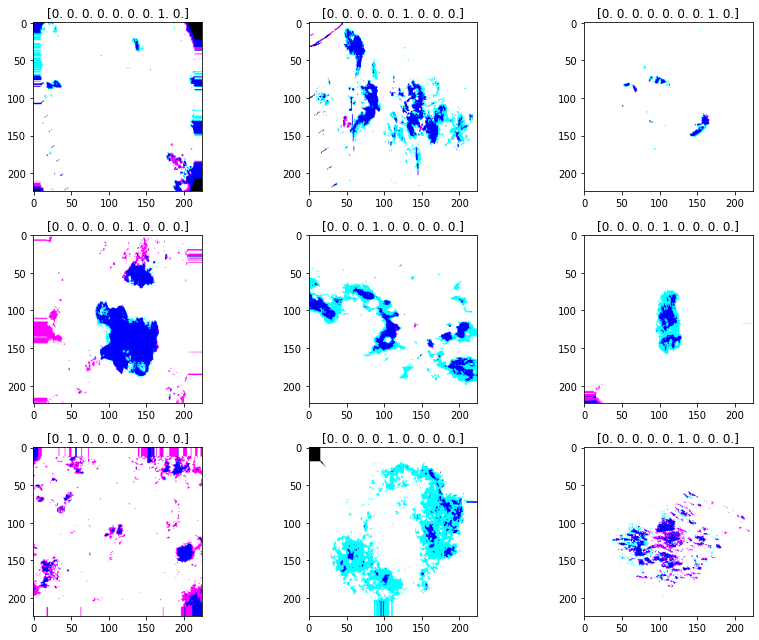

In [ ]:
fit, ax = plt.subplots(nrows=3, ncols=3, figsize=(12,9))

for i, a in enumerate(ax.flat):
    img, label = X_train.next()
    a.imshow(img[0],)
    a.set_title(label[0])

plt.tight_layout()
plt.show()

Create and compile the model

# ResNet Transfer Learning
Model from https://github.com/AnasBrital98/CNN-From-Scratch/tree/master/Inception-V3

In [ ]:
# count of epchos
EPOCHS = 100

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input
from tensorflow.keras.models import Model
import numpy as np

# this could also be the output a different Keras model or layer
input_tensor = Input(shape=(224, 224, 3))
# create the base pre-trained model
base_model = ResNet50(input_tensor=input_tensor, weights='imagenet', include_top=False)
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(9, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
#model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=[
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.AUC(),
        "accuracy"
    ])

# train the model on the new data for a few epochs
hst = model.fit(X_train, validation_data=X_val, epochs=EPOCHS)

94781440/94765736 [==============================] - 1s 0us/step
Epoch 1/100
56/56 [==============================] - 73s 1s/step - loss: 1.9223 - precision: 0.5479 - recall: 0.3004 - auc: 0.8042 - accuracy: 0.4534 - val_loss: 1.2795 - val_precision: 0.7143 - val_recall: 0.4241 - val_auc: 0.8933 - val_accuracy: 0.5759
Epoch 2/100
56/56 [==============================] - 62s 1s/step - loss: 1.0735 - precision: 0.7334 - recall: 0.4869 - auc: 0.9268 - accuracy: 0.6153 - val_loss: 1.1780 - val_precision: 0.6940 - val_recall: 0.4911 - val_auc: 0.9128 - val_accuracy: 0.5804
Epoch 3/100
56/56 [==============================] - 56s 1s/step - loss: 0.9446 - precision: 0.7582 - recall: 0.5427 - auc: 0.9435 - accuracy: 0.6583 - val_loss: 1.2416 - val_precision: 0.6441 - val_recall: 0.5089 - val_auc: 0.9086 - val_accuracy: 0.6027
Epoch 4/100
56/56 [==============================] - 56s 1s/step - loss: 0.8969 - precision: 0.7582 - recall: 0.5779 - auc: 0.9488 - accuracy: 0.6773 - val_loss: 1.2082 -

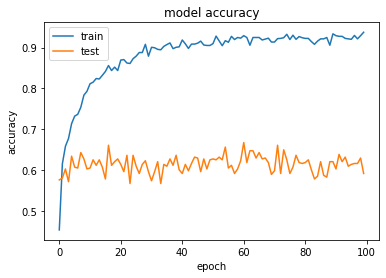

In [ ]:
# summarize history for accuracy
plt.plot(hst.history['accuracy'])
plt.plot(hst.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

0 input_1
1 conv1_pad
2 conv1_conv
3 conv1_bn
4 conv1_relu
5 pool1_pad
6 pool1_pool
7 conv2_block1_1_conv
8 conv2_block1_1_bn
9 conv2_block1_1_relu
10 conv2_block1_2_conv
11 conv2_block1_2_bn
12 conv2_block1_2_relu
13 conv2_block1_0_conv
14 conv2_block1_3_conv
15 conv2_block1_0_bn
16 conv2_block1_3_bn
17 conv2_block1_add
18 conv2_block1_out
19 conv2_block2_1_conv
20 conv2_block2_1_bn
21 conv2_block2_1_relu
22 conv2_block2_2_conv
23 conv2_block2_2_bn
24 conv2_block2_2_relu
25 conv2_block2_3_conv
26 conv2_block2_3_bn
27 conv2_block2_add
28 conv2_block2_out
29 conv2_block3_1_conv
30 conv2_block3_1_bn
31 conv2_block3_1_relu
32 conv2_block3_2_conv
33 conv2_block3_2_bn
34 conv2_block3_2_relu
35 conv2_block3_3_conv
36 conv2_block3_3_bn
37 conv2_block3_add
38 conv2_block3_out
39 conv3_block1_1_conv
40 conv3_block1_1_bn
41 conv3_block1_1_relu
42 conv3_block1_2_conv
43 conv3_block1_2_bn
44 conv3_block1_2_relu
45 conv3_block1_0_conv
46 conv3_block1_3_conv
47 conv3_block1_0_bn
48 conv3_block1_3_bn

In [ ]:
# we chose to train the top 2 resnet blocks, i.e. we will freeze
# the first 49 layers and unfreeze the rest:
limit = 171
for layer in model.layers[:limit]:
   layer.trainable = False
for layer in model.layers[limit:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from tensorflow.keras.optimizers import SGD
model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=[
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.AUC(),
        "accuracy"
    ])

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
hst = model.fit(X_train, validation_data=X_val, epochs=EPOCHS)

Epoch 1/100
56/56 [==============================] - 65s 1s/step - loss: 0.2624 - precision_1: 0.9068 - recall_1: 0.8911 - auc_1: 0.9935 - accuracy: 0.8989 - val_loss: 1.9970 - val_precision_1: 0.6446 - val_recall_1: 0.6317 - val_auc_1: 0.8940 - val_accuracy: 0.6406
Epoch 2/100
56/56 [==============================] - 57s 1s/step - loss: 0.1703 - precision_1: 0.9266 - recall_1: 0.9162 - auc_1: 0.9974 - accuracy: 0.9218 - val_loss: 1.9620 - val_precision_1: 0.6267 - val_recall_1: 0.6071 - val_auc_1: 0.8969 - val_accuracy: 0.6183
Epoch 3/100
56/56 [==============================] - 55s 984ms/step - loss: 0.1504 - precision_1: 0.9346 - recall_1: 0.9263 - auc_1: 0.9984 - accuracy: 0.9302 - val_loss: 1.9503 - val_precision_1: 0.6605 - val_recall_1: 0.6339 - val_auc_1: 0.8898 - val_accuracy: 0.6429
Epoch 4/100
56/56 [==============================] - 55s 989ms/step - loss: 0.1331 - precision_1: 0.9424 - recall_1: 0.9324 - auc_1: 0.9985 - accuracy: 0.9375 - val_loss: 2.0232 - val_precision_1:

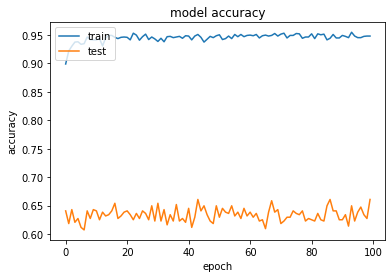

In [ ]:
# summarize history for accuracy
plt.plot(hst.history['accuracy'])
plt.plot(hst.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Load test data

In [ ]:
X_test = load_data('Skin cancer ISIC The International Skin Imaging Collaboration/Test')

Print head data

In [ ]:
X_test.head(3)

,FilePaths,Labels
0,Skin cancer ISIC The International Skin Imagin...,nevus
1,Skin cancer ISIC The International Skin Imagin...,melanoma
2,Skin cancer ISIC The International Skin Imagin...,nevus


In [ ]:
print('Test Data: ', X_test.shape)

# ordered count of rows per unique label
X_test['Labels'].value_counts(ascending=True)

Test Data:  (118, 2)


vascular lesion                3
seborrheic keratosis           3
nevus                         16
melanoma                      16
actinic keratosis             16
basal cell carcinoma          16
pigmented benign keratosis    16
dermatofibroma                16
squamous cell carcinoma       16
Name: Labels, dtype: int64

Preprocess test image

In [ ]:
# image preprocessing
X_test = img_data_gen.flow_from_dataframe(dataframe=X_test,
                                          x_col='FilePaths',
                                          y_col='Labels',
                                          target_size=IMG_SIZE,
                                          color_mode='rgb',
                                          class_mode='categorical',
                                          batch_size=BATCH_SIZE,
                                          shuffle=False, # necessary fpr confusion matrix
                                          seed=1)

Found 118 validated image filenames belonging to 9 classes.


Evaluate model againts test data

In [ ]:
res = model.evaluate(X_test)

4/4 [==============================] - 9s 2s/step - loss: 4.2174 - precision_1: 0.5128 - recall_1: 0.5085 - auc_1: 0.7996 - accuracy: 0.5169


The accuracy

In [ ]:
# accuracy
print(f'Train Accuracy: {hst.history["accuracy"][-1:][0] * 100:.2f}')
print(f'Val Accuracy: {hst.history["val_accuracy"][-1:][0] * 100:.2f}')
print(f'Test Accuracy: {res[1] * 100:.2f}')
# loss
print(f'Train Loss: {hst.history["loss"][-1:][0] * 100:.2f}')
print(f'Val Loss: {hst.history["val_loss"][-1:][0] * 100:.2f}')
print(f'Test Loss: {res[0] * 100:.2f}')

Train Accuracy: 94.81
Val Accuracy: 66.07
Test Accuracy: 51.28
Train Loss: 9.21
Val Loss: 172.75
Test Loss: 421.74


Calculate y_pred

In [ ]:
# predicted labels
Y_pred = model.predict(X_test)
print("Y_pred", Y_pred.shape)
# rounded labels
y_pred = np.argmax(Y_pred, axis=1)
print("y_pred", y_pred.size)

Y_pred (118, 9)
y_pred 118


Calculate y_true

In [ ]:
# true labels
y_true = X_test.classes
print("y_pred", len(y_pred))
# label classes
class_labels = list(X_test.class_indices.keys())
print("labels", len(class_labels))

y_pred 118
labels 9


The confusion metric

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib.ticker import FuncFormatter
import textwrap as tw

[Text(0.5, 0, 'actinic\nkeratosis'),
 Text(1.5, 0, 'basal cell\ncarcinoma'),
 Text(2.5, 0, 'dermatofib\nroma'),
 Text(3.5, 0, 'melanoma'),
 Text(4.5, 0, 'nevus'),
 Text(5.5, 0, 'pigmented\nbenign\nkeratosis'),
 Text(6.5, 0, 'seborrheic\nkeratosis'),
 Text(7.5, 0, 'squamous\ncell\ncarcinoma'),
 Text(8.5, 0, 'vascular\nlesion')]

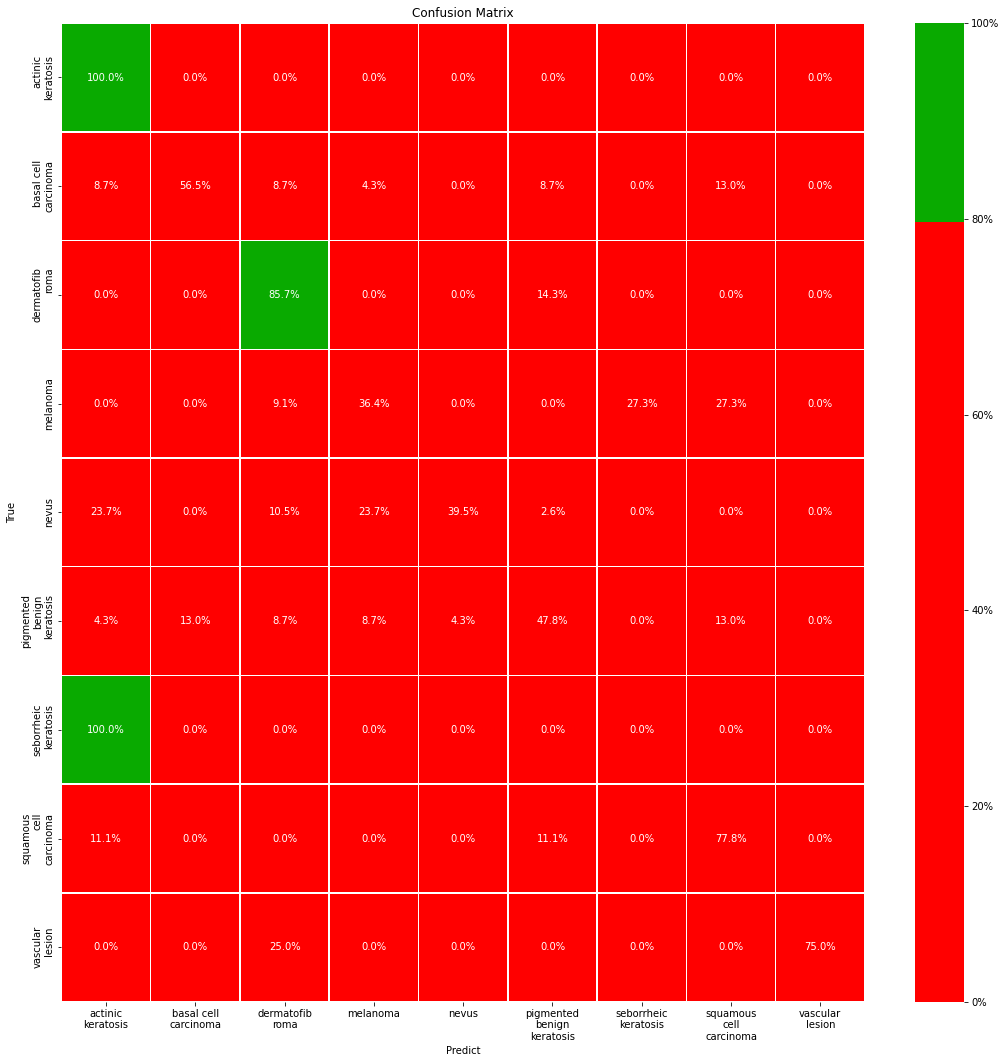

In [ ]:
# compare with true labels
cfm = confusion_matrix(y_pred, y_true, normalize='true')

# plot size
fig, ax = plt.subplots(figsize=(18,18))
# print confusion matrix
s = sns.heatmap(cfm,
               annot=True,
               cmap=['#ff0000', '#09AA00'],
               center=0.8,
               fmt='.1%',
               linewidths=.5,
               cbar_kws={'format': FuncFormatter(lambda x, pos: '{:.0%}'.format(x))}, #'label': 'Percentage' 
               linecolor='white',
               ax=ax)
# set labels
s.set(xlabel='Predict', ylabel='True')
s.set(title='Confusion Matrix')
s.set_yticklabels([tw.fill(e, 10) for e in class_labels])
s.set_xticklabels([tw.fill(e, 10) for e in class_labels])